This jupyter notebook
- Read EMG data of 12 walking trials and an MVC trial of one subject
- Illustrate the EMG processing in 8 steps
- Visualize the processed data of the walking trials

### Import packages

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import signal
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import mwarp1d
import projpath ## data path setting
from rris_trial_data import * ## data preprocessing of some RRIS specific formats into a standard format
from emg_processing import * ## emg processing

# Read data

In [2]:
trial_names, trial_data = read_data()
trial_gait_cycle = read_trial_gait_cycle()

### Select illustration example

In [3]:
trial_name = '0004'
muscle = 'R.Glut.Med.'
limb = 'R'

In [4]:
tidx = trial_names.index(trial_name)
cidx = list(trial_data[tidx].columns).index(muscle)
data = trial_data[tidx].copy()
gait_cycle_info = trial_gait_cycle[(trial_gait_cycle['trial_name']==trial_name) & (trial_gait_cycle['limb']==limb)]

### Display sample data (standard format of current version)

In [5]:
display(data.head(5))

,timestamp,L.Glut.Max.,L.Glut.Med.,L.Semitend.,L.Biceps Fem.,L.Med. Gastro,L.Lat. Gastro,L.Vmo,L.Vlo,R.Glut.Max.,R.Glut.Med.,R.Semitend.,R.Biceps Fem.,R.Med. Gastro,R.Lat. Gastro,R.Vmo,R.Vlo
0,0.0000,-60.884,13.885,-5.646,9.308,-188.449,-3.815,12.360,-3.204,-12.970,12.054,-4.425,11.444,-165.256,-22.736,6.866,5.951
1,0.0005,-65.461,13.275,12.665,-15.106,-161.288,-1.068,10.223,-4.730,-5.035,18.463,-7.477,-1.373,-109.713,-37.080,15.717,2.594
2,0.0010,-57.527,12.360,16.937,-19.989,-121.309,-3.510,13.885,0.458,-9.613,12.054,3.510,2.289,-9.003,-30.670,11.139,1.068
3,0.0015,-64.240,16.632,1.678,-14.496,-59.052,0.153,9.308,-2.594,-10.529,14.496,0.153,-1.068,96.895,-20.599,-7.782,4.425
4,0.0020,-64.546,9.308,-27.008,-12.054,86.213,7.477,4.120,-1.373,-7.477,14.801,-2.594,7.782,153.353,12.665,1.068,9.613


# Illustrate steps

### 0. Original signal

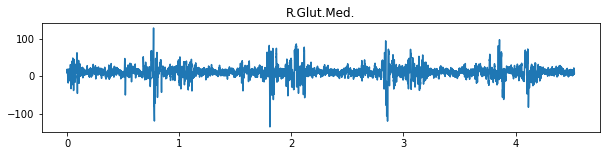

In [6]:
plot_signal(data, cidx)

### 1. Remove DC offset

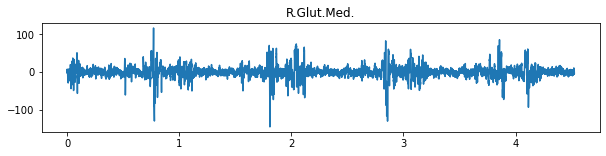

In [7]:
data[muscle] = remove_dc_offset(data[muscle])
plot_signal(data, cidx)

### 2. Apply bandpass filter

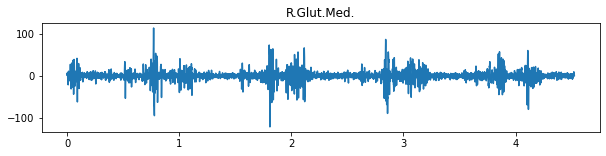

In [8]:
data[muscle] = apply_bandpass_filter(data[muscle], frequency)
plot_signal(data, cidx)

### 3. Apply full wave rectify

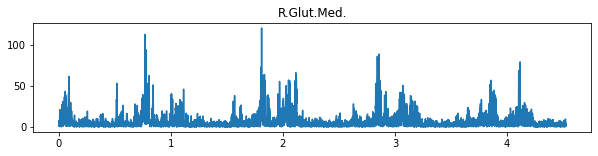

In [9]:
data[muscle] = apply_full_wave_rectify(data[muscle])
plot_signal(data, cidx)

### 4. Apply linear envelope

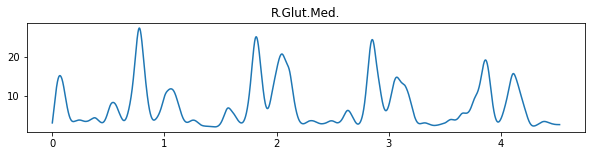

In [10]:
data[muscle] = apply_linear_envelope(data[muscle], frequency)
plot_signal(data, cidx)

### 5. Cut off end frames

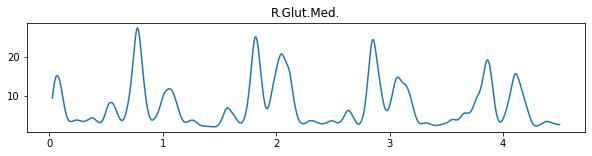

In [11]:
trial_data = all_trials_process_initial_steps(trial_data, frequency)
trial_data = all_trials_cut_off_end_frames(trial_data, 50)
plot_signal(trial_data[tidx], cidx)

### 6. Normalize amplitude by MVC

In [12]:
mvc, max_signal_values = find_mvc_of_all_trials(trial_names, trial_data)
# print('Max signal value of the trials (walking trials & mvc trial)":')
# display(max_signal_values)
print('MVC:')
print(mvc)
print(f'MVC of "{muscle}" is {mvc[muscle]:.2f} uV')

MVC:
L.Glut.Max.       75.116889
L.Glut.Med.       81.345924
L.Semitend.      191.178179
L.Biceps Fem.    135.866605
L.Med. Gastro    206.889923
L.Lat. Gastro    257.875165
L.Vmo            207.922885
L.Vlo            180.279112
R.Glut.Max.       47.235020
R.Glut.Med.       46.654658
R.Semitend.      263.760340
R.Biceps Fem.    133.534685
R.Med. Gastro    233.695968
R.Lat. Gastro    195.013644
R.Vmo            185.678987
R.Vlo            156.007567
dtype: float64
MVC of "R.Glut.Med." is 46.65 uV


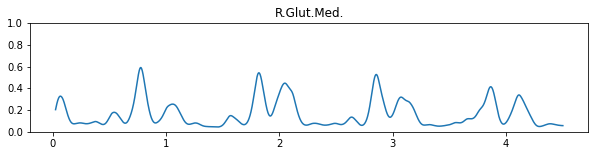

In [13]:
trial_data = all_trials_normalize_amplitude_by_mvc(trial_names, trial_data)
del trial_names[-1]
del trial_data[-1]
plot_signal(trial_data[tidx], cidx, ymin=0, ymax=1)

### 7. Segment gait cycle

,trial_name,limb,action,timestamp,cycle_pct
0,0004,R,RHS,1.759,0.0
1,0004,R,RTO,2.399,0.6
2,0004,R,RHS,2.789,1.0


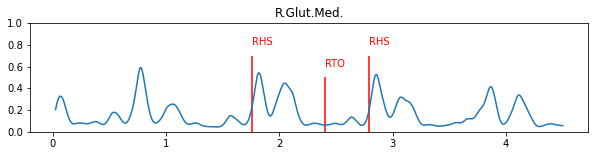

In [14]:
display(gait_cycle_info)
plot_signal(trial_data[tidx], cidx, ymin=0, ymax=1, gait_cycle_info=gait_cycle_info)

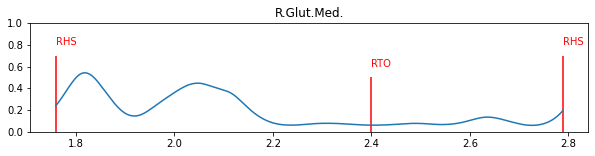

In [15]:
seg_trial_names, seg_trial_data = all_trials_segment(trial_names, trial_data, trial_gait_cycle)
tidx = seg_trial_names[limb].index(trial_name)
plot_signal(seg_trial_data[limb][tidx], cidx, ymin=0, ymax=1, gait_cycle_info=gait_cycle_info)

### 8. Normalize time by gait cycle

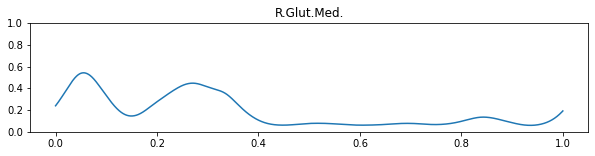

In [16]:
seg_trial_data = all_trials_normalize_time_by_gait_cycle(seg_trial_names, seg_trial_data, trial_gait_cycle)
plot_signal(seg_trial_data[limb][tidx], cidx, ymin=0, ymax=1)

# Visualize all processed data of the walking trials

### Left limb

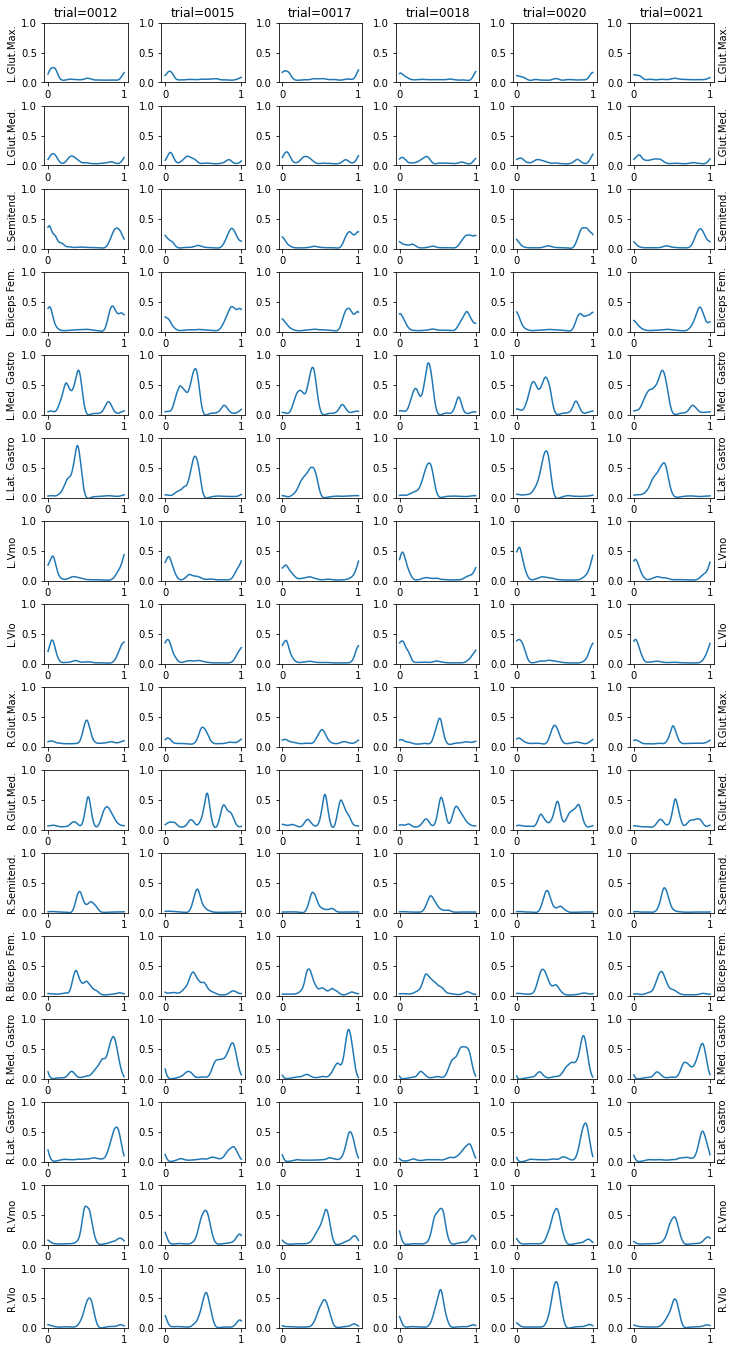

In [17]:
plot_muscle_vs_trial_final_signals(seg_trial_names, seg_trial_data, 'L')

### Right limb

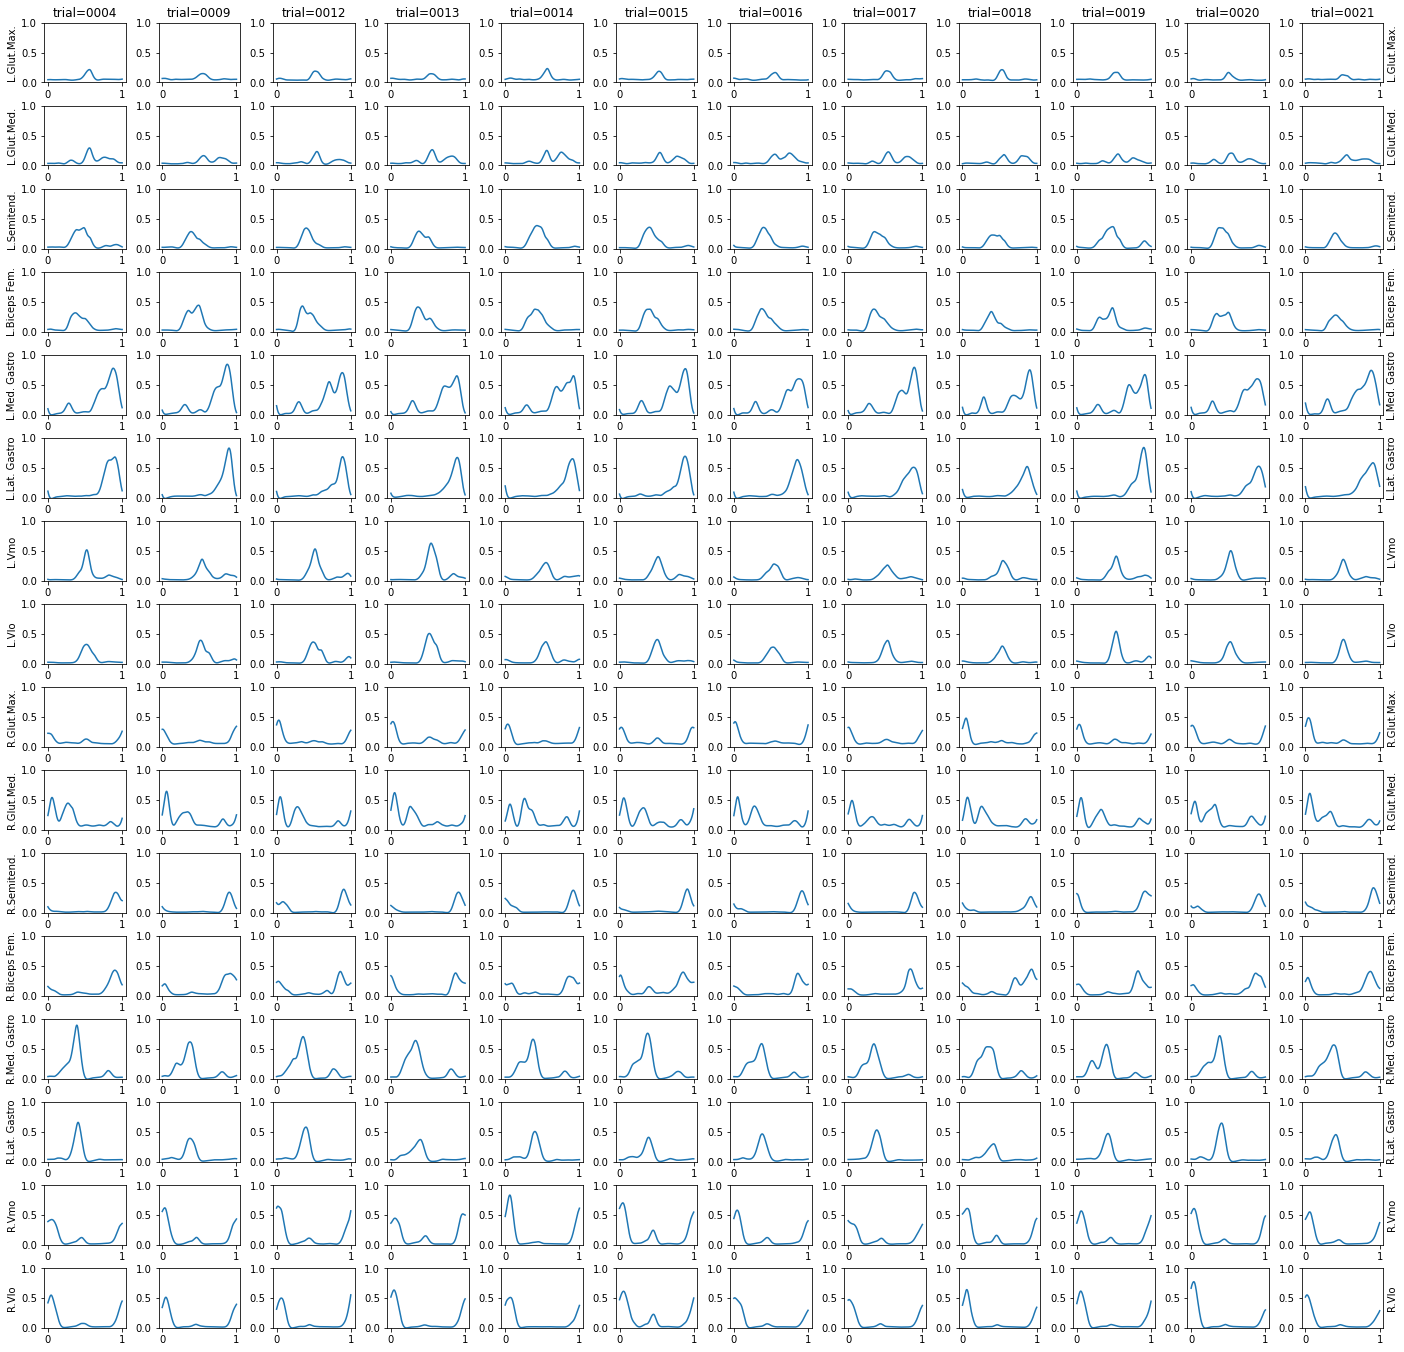

In [18]:
plot_muscle_vs_trial_final_signals(seg_trial_names, seg_trial_data, 'R')

### Left and right limb, overlap trials

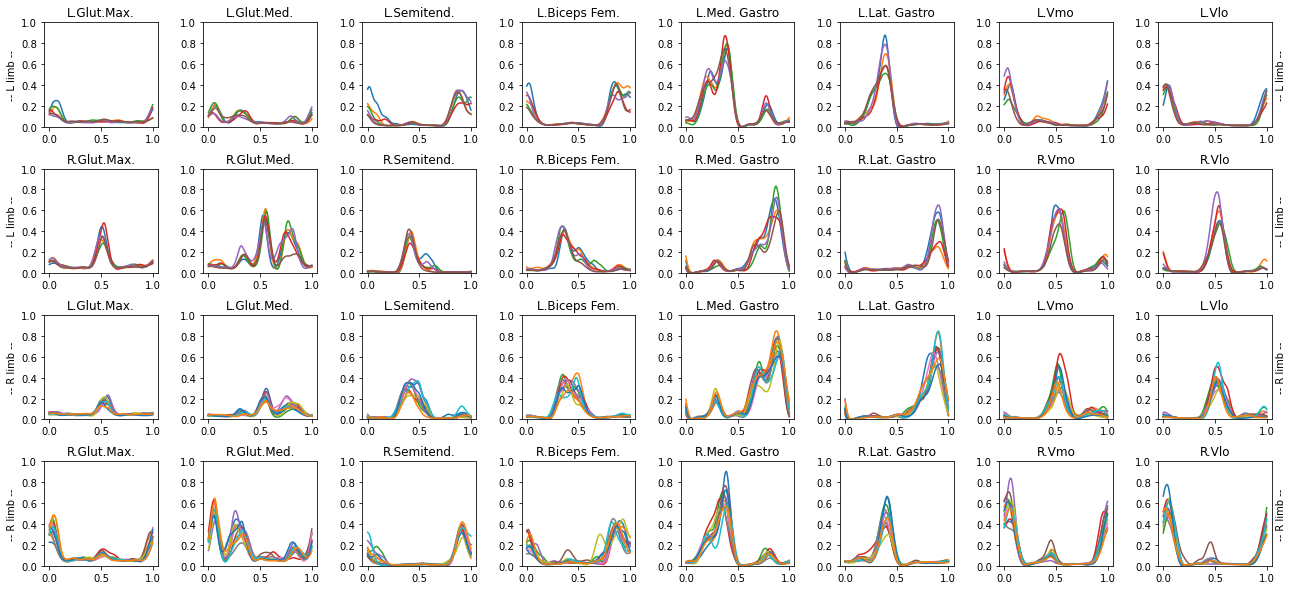

In [19]:
nrows, ncols = 4, 8
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(22, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

limb = 'L'
m = 0
for r in range(2):
    for c in range(ncols):
        for data in seg_trial_data[limb]:
            axes[r][c].plot(data.iloc[:,0], data.iloc[:,m+1], '-');
        axes[r][c].set_ylim(0, 1);
        axes[r][c].set_title(f'{data.columns[m+1]}')
        if c == 0:
            axes[r][c].set_ylabel(f'-- {limb} limb --')
        elif c == ncols - 1:
            axes[r][c].yaxis.set_label_position('right')
            axes[r][c].set_ylabel(f'-- {limb} limb --')
        m += 1

limb = 'R'
m = 0
for r in range(2,4):
    for c in range(ncols):
        for data in seg_trial_data[limb]:
            axes[r][c].plot(data.iloc[:,0], data.iloc[:,m+1], '-');
        axes[r][c].set_ylim(0, 1);
        axes[r][c].set_title(f'{data.columns[m+1]}')
        if c == 0:
            axes[r][c].set_ylabel(f'-- {limb} limb --')
        elif c == ncols - 1:
            axes[r][c].yaxis.set_label_position('right')
            axes[r][c].set_ylabel(f'-- {limb} limb --')
        m += 1